In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import os
import glob

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

from agentfil import plot_utils

import copy

In [13]:
purples = mpl.colormaps['Purples']
blues = mpl.colormaps['Blues']
greens = mpl.colormaps['Greens']
oranges = mpl.colormaps['Oranges']
reds = mpl.colormaps['Reds']
colors = [blues, oranges, greens, purples, reds]

In [14]:
results_root_dir=os.path.join(os.environ['HOME'],'agentfil','lock_target', 'exp')

rb_onboard = 6
renewal_rate = 0.6
filp_agent_power = 0.5
fil_supply_discount_rate = 20

filplus_agent_discount_rate = 25
normal_cc_agent_discount_rate_multiplier = 1
filplus_agent_optimism = 4
normal_cc_agent_optimism = 4
normal_cc_agent_discount_rate = filplus_agent_discount_rate * normal_cc_agent_discount_rate_multiplier

lock_target_vec = [0.4, 0.5, 0.6]
#lock_target_dynamics_vec = ['jump', 'linear-3', 'linear-6', 'linear-12']
lock_target_dynamics_vec = ['jump', 'linear-12']

experiment_dirs = []
experiment_names = []
plt_kwargs_list = []

baseline_fpr = 0.8
baseline_sector_duration = 360
baseline_folder = os.path.join(os.environ['HOME'],'agentfil','baseline')
baseline_experiment = 'BaselineDCA_RBP_%0.02f-RR_%0.02f-FPR_%0.02f-Dur_%0.02f' % \
                (rb_onboard, renewal_rate, baseline_fpr, baseline_sector_duration)
baseline_filecoin_df = pd.read_csv(os.path.join(baseline_folder, baseline_experiment, 'filecoin_df.csv'))

cmap_access_vec = np.linspace(0.3, 0.8, len(lock_target_vec))
for ii, lock_target_dynamic in enumerate(lock_target_dynamics_vec):
    for jj, lock_target in enumerate(lock_target_vec):
        if lock_target_dynamic == 'jump':
            lock_target_cfg_str = 'LockTarget[%0.1f,jump]' % (lock_target,)
        else:
            lag_mo = lock_target_dynamic.split('-')[1]
            lock_target_cfg_str = 'LockTarget[%0.1f,%s,%s]' % (lock_target, 'linear_ramp', lag_mo)
        
        name = '%s,FILP_%d,%d,%0.02f,CC_%d,%d,Onboard_%0.02f,RR_%0.02f,DR_%d' % \
            (
                lock_target_cfg_str,
                filplus_agent_optimism, filplus_agent_discount_rate, filp_agent_power,
                normal_cc_agent_optimism, normal_cc_agent_discount_rate, 
                rb_onboard, renewal_rate, fil_supply_discount_rate,
            )
        
        experiment_dirs.append(name)
        plt_kwargs = {
            'color': colors[ii](cmap_access_vec[jj])
        }
        plt_kwargs_list.append(plt_kwargs)
        experiment_names.append('%s' % (lock_target_cfg_str, ))
        

# plot settings
min_agent_plot_date = date(2023, 4, 1)
max_agent_plot_date = date(2026, 12, 31)

min_kpi_plot_date = None
max_kpi_plot_date = date(2026, 12, 31)

save_dir = os.path.join('/Users/kiran/Documents/ced_austin')

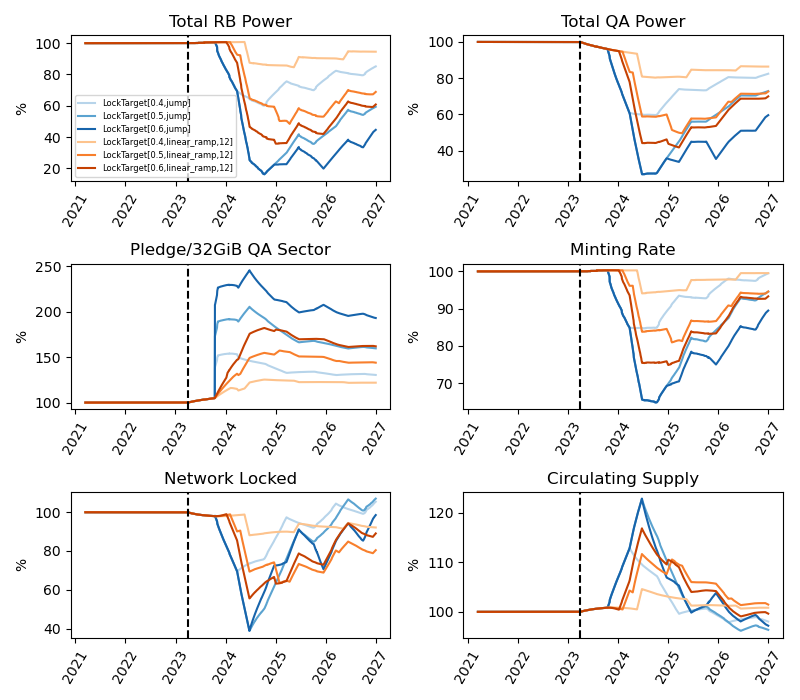

In [15]:
x_post_fn = plot_utils.x_post_fn
plt_baseline_relative = True

plt.figure(figsize=(8,7))

plt.subplot(3,2,1)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['total_raw_power_eib'], experiment_dirs, 
    x_post_process=x_post_fn, 
    y_post_process=None,
    x_key='date', labels=experiment_names,
    min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
    plot_kwargs_list=plt_kwargs_list,
    baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Total RB Power')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.ylabel('EiB')
plt.legend(fontsize=6)


plt.subplot(3,2,2)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['total_qa_power_eib'], experiment_dirs, 
    x_post_process=x_post_fn, 
    y_post_process=None,
    min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
    x_key='date', labels=None, plot_kwargs_list=plt_kwargs_list,
    baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Total QA Power')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.ylabel('EiB')

plt.subplot(3,2,3)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['day_pledge_per_QAP'], experiment_dirs, 
    x_post_process=x_post_fn, 
    y_post_process=None,
    min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
    x_key='date', labels=None, plot_kwargs_list=plt_kwargs_list,
    baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Pledge/32GiB QA Sector')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.ylabel('FIL')

plt.subplot(3,2,4)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['day_network_reward'], experiment_dirs, 
    x_post_process=x_post_fn, 
    y_post_process=None,
    min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
    x_key='date', labels=None, plot_kwargs_list=plt_kwargs_list,
    baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Minting Rate')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.ylabel('FIL/day')
    

plt.subplot(3,2,5)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['network_locked'], experiment_dirs, 
    x_post_process=x_post_fn, 
    y_post_process=plot_utils.converttoMFIL,
    min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
    x_key='date', labels=None, plot_kwargs_list=plt_kwargs_list,
    baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Network Locked')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.ylabel('M-FIL')

plt.subplot(3,2,6)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['circ_supply'], experiment_dirs, 
    x_post_process=x_post_fn, 
    y_post_process=plot_utils.converttoMFIL,
    min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
    x_key='date', labels=None, plot_kwargs_list=plt_kwargs_list,
    baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Circulating Supply')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.ylabel('M-FIL')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'lock_target_kpi.png'))

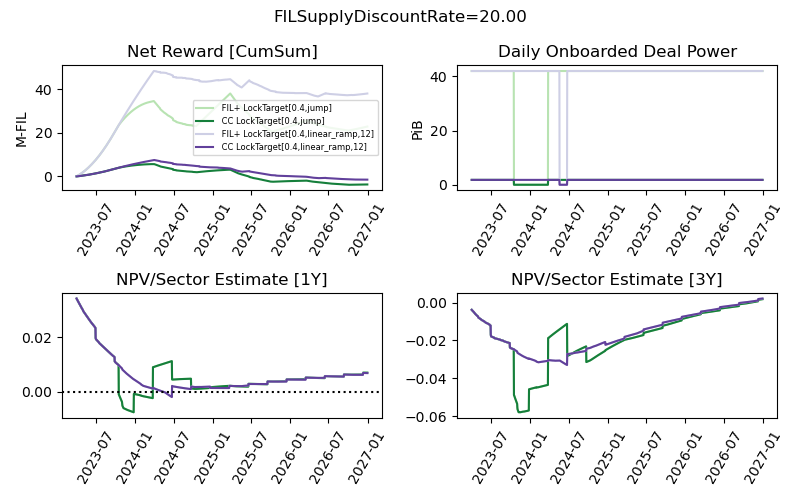

In [18]:
colors = [greens, purples, blues, oranges, reds]

lock_target = 0.4
lock_target_dynamics_vec = ['jump', 'linear-12']

experiment_dirs = []
experiment_names = []
plt_kwargs_list = []

for ii, lock_target_dynamic in enumerate(lock_target_dynamics_vec):
    if lock_target_dynamic == 'jump':
        lock_target_cfg_str = 'LockTarget[[]%0.1f,jump[]]' % (lock_target,)
        lock_target_cfg_str_print = 'LockTarget[%0.1f,jump]' % (lock_target,)
    else:
        lag_mo = lock_target_dynamic.split('-')[1]
        lock_target_cfg_str = 'LockTarget[[]%0.1f,%s,%s[]]' % (lock_target, 'linear_ramp', lag_mo)
        lock_target_cfg_str_print = 'LockTarget[%0.1f,%s,%s]' % (lock_target, 'linear_ramp', lag_mo)

    name = '%s,FILP_%d,%d,%0.02f,CC_%d,%d,Onboard_%0.02f,RR_%0.02f,DR_%d' % \
            (
                lock_target_cfg_str,
                filplus_agent_optimism, filplus_agent_discount_rate, filp_agent_power,
                normal_cc_agent_optimism, normal_cc_agent_discount_rate, 
                rb_onboard, renewal_rate, fil_supply_discount_rate,
            )

    experiment_dirs.append(name)
    plt_kwargs = [{'color': colors[ii](0.3)}, {'color': colors[ii](0.8)}]
    plt_kwargs_list.append(plt_kwargs)
    experiment_names.append('%s' % (lock_target_cfg_str_print,))

per_agent_label_list = ['FIL+', 'CC']

plt.figure(figsize=(8,5))

plt.subplot(2,2,1)
keys = ['reward_FIL', 'pledge_interest_payment_FIL']
def compute_net_reward_FIL(key_data):
    net_reward_FIL = key_data['reward_FIL'].cumsum() - key_data['pledge_interest_payment_FIL'].cumsum()
    return net_reward_FIL/1_000_000
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_utils.plot_agent(
        results_root_dir,
        ['reward_FIL', 'pledge_interest_payment_FIL'], e,
        x_post_process=x_post_fn,
        y_post_process=compute_net_reward_FIL, 
        df_name='accounting_df', 
        label_postpend=exp_name, 
        per_agent_label_list=per_agent_label_list,
        plot_kwargs_list=plt_kwargs_list[ii],
        min_date = min_agent_plot_date, max_date = max_agent_plot_date,
      )
plt.title('Net Reward [CumSum]')
plt.ylabel('M-FIL')
plt.legend(fontsize=6)

plt.subplot(2,2,2)
def compute_deal_onboarded(key_data):
    total_onboards = key_data['deal_onboarded']
    return total_onboards
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_utils.plot_agent(
        results_root_dir,
        ['cc_onboarded', 'cc_renewed', 'deal_onboarded'], e,
               x_post_process=x_post_fn,
               y_post_process=compute_deal_onboarded, 
               df_name='agent_info_df', 
               label_postpend=exp_name,  
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii],
               min_date = min_agent_plot_date, max_date = max_agent_plot_date,
              )
plt.title('Daily Onboarded Deal Power')
plt.ylabel('PiB')

plt.subplot(2,2,3)
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_utils.plot_agent(
        results_root_dir,
        ['npv_estimate_365'], e,
               x_post_process=x_post_fn,
               y_post_process=None, 
               df_name='agent_info_df', 
               label_postpend=exp_name,  
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii],
               min_date = min_agent_plot_date, max_date = max_agent_plot_date,
              )
plt.title('NPV/Sector Estimate [1Y]')
plt.axhline(0, color='k', linestyle=':')

plt.subplot(2,2,4)
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_utils.plot_agent(
        results_root_dir,
        ['npv_estimate_1095'], e,
               x_post_process=x_post_fn,
               y_post_process=None, 
               df_name='agent_info_df', 
               label_postpend=exp_name,  
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii],
               min_date = min_agent_plot_date, max_date = max_agent_plot_date,
              )
plt.title('NPV/Sector Estimate [3Y]')

plt.suptitle('FILSupplyDiscountRate=%0.02f' % \
             (fil_supply_discount_rate,))

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'lock_target_agents.png'))

In [17]:
"""
Immediate takeaway - gradual increase of lock-target enables less RBP drop, look at NPV estimates. 

TODO: explore this a bit more to see if there's anythign else thats interesting.
"""

"\nImmediate takeaway - gradual increase of lock-target enables less RBP drop, look at NPV estimates. \n\nTODO: explore this a bit more to see if there's anythign else thats interesting.\n"